In the highly-dynamic movement of machine learning, finding ways of utilizing resources at near-optimum efficieny in the algorithm development is a major point to address. HuggingFacehub has a vast resource of datasets machine learning enthusiasts can directly apply to their use cases straight away. 

This notebook will go over a series of modification of datasets to make the data in better shape for model training. For the deep learning development, it will be covered in another notebook `Modelling.ipynb`.

Steps includes:
1)  visual analysis
2) image preprocessing
3) image transformation.

### Image Modification

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [2]:
# External libraries
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
import os
import sys
from pathlib import Path
import shutil
import glob

In [19]:
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PARENT_DIR

'D:\\github_repos\\mlzoomcamp\\image_classification_trash'

The collection of trash images is available in HuggingFace Hub. Thankfully, HuggingFace got that covered as the library `datasets` offers much simpler way to prepare data. *Datasets* lets us access major public datasets and download and preprocess any of them, all done in one line code. With a single command `dataset = load_dataset("cifar-10")`, these datasets ready to use in a dataloader format that popular ML libraries such as PyTorch, TensorFlow, and JAX can directly train and evaluate.

In [7]:
# Import library 'datasets'
from datasets import load_dataset

dataset = load_dataset("garythung/trashnet")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

If we want to develop deep learning model capable of recognizing patterns from given data, a quick analysis on dataset is always prioritized. As the dataset is delivered from HuggingFace hub, we expect HuggingFace Dataset Object provide functions and methods that makes the analysis easier.

In [8]:
dataset['train'].shape

(5054, 2)

Without having to write a custom code to do the job of map and filter classes, we can access `datasets.ClassLabel` feature to get a better view of image and label structures. For the trash type, how does the structure look like?

In [9]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)}

We get the information of label from `features` method. Let's count how many classes the dataset has, also the name of each class.

In [10]:
dataset['train'].features['label'].num_classes

6

In [11]:
dataset['train'].features['label'].names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [12]:
list_object = dataset['train'].features['label'].names

The information of the name and number of classes gives what objects captured in the images:
- cardboard
- glass
- metal
- paper
- plastic
- trash

We establish the dict format of claasses for the purpose of labelling images.

In [13]:
class_map = dict(zip(list(range(0, len(list_object))), list_object))
class_map

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

Using Counter from collections, the count of each class is available to read.

In [55]:
from collections import Counter

Counter(dataset['train']['label'])

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 274})

Looking at its label proportions, paper stands the most frequent while trash remain the bottom of the rank. One point to address is the large difference in the entire classes, showing a sign of imbalance. We may need to deal with this issue when developing deep learning.

### 1.1 Input and output shapes of a computer vision model

To see the dimension of images we convert images that are initially in PIL format to torcy-type tensors with the torchvision transforms.

In [15]:
import torchvision.transforms as transforms

# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
image_tensor = transform(dataset['train'][0]['image'])

In [16]:
# See first training sample
image_tensor.shape

torch.Size([3, 4032, 3024])

The shape of the image tensor is [3, 4032, 3024], meaning that the image comes in RGB with the dimension of 4032 for height and 3024 for width. Remember that PyTorch generally recognize `CHW` as the default for many operators. Since its dimension is very large, our realistic thought is that the dataset is populated with images around that dimension. It's often suggested that we apply resizing methods on images to shrink them with a smaller and equal size.

The dataset comes in dictionary form, so we access key 'image' to visualize a randomly selected image and key 'label' to view which item class that falls into.

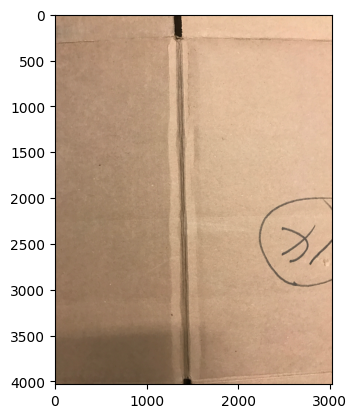

Label: cardboard


In [17]:
img = dataset['train'][0]['image']
label = int(dataset['train'][0]['label'])
plt.imshow(img)
plt.show()
print(f"Label: {class_map[label]}")

Let's bring some more images in random fashion.

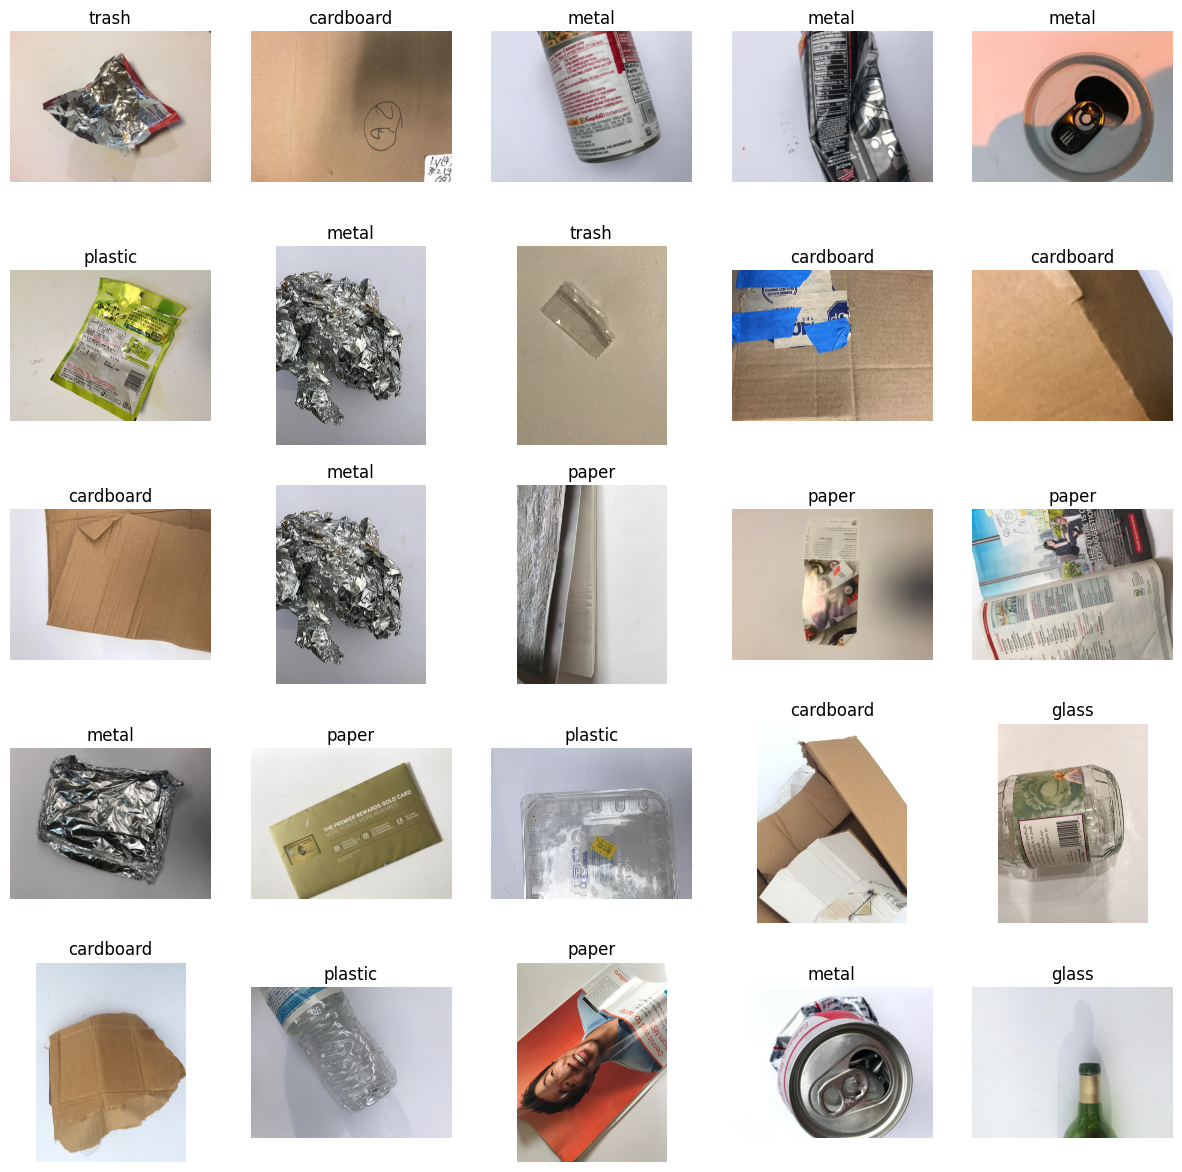

In [31]:
# Plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset['train']), size=[1]).item()
    img, label = dataset['train'][random_idx]['image'], dataset['train'][random_idx]['label']
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_map[label])
    plt.axis(False);

Excellent! The visual showing of randomly selected images with Matplotlib gives us a comprehensive look at what objects that we expect deep learning to learn and recognize. Also the image labelling fed from a customized dictionary works out well too.

### Saving HuggingFace Images and Labels into Directories for safe and easy reload

As we notice earlier, the dataset is provided only in train set. Machine learning is expected to run through different sets composed of train and test (or train, validation, and test), we will employ few steps of separating portions of data from the original train set. This process begins by gathering indexes in random before commencing data splitting. The outcome will be in three sets with each set having own directory. 

In [20]:
## Setting a directory for storing data in raw folder.
os.path.join(PARENT_DIR, "data", "raw")

'D:\\github_repos\\mlzoomcamp\\image_classification_trash\\data\\raw'

In [23]:
# Directory where images will be saved
output_dir = "trash_images"

# Set new directory for images
IMAGE_DIR = os.path.join(PARENT_DIR, "data", "raw", output_dir)

# Create the directory if it doesn't exist
os.makedirs(IMAGE_DIR, exist_ok=True)

In [24]:
import os
import numpy as np
from scipy import misc, ndimage

Our next question in splitting data comes to how to ensure labels (or classes) are evenly distributed despite having label imbalance. We rely on Scikit learn selection of `train_test_split` to produce lists of indexes based on the length of training set and the stratification of labels.

In [25]:
from sklearn.model_selection import train_test_split

In [36]:
train_data = dataset['train']
labels = train_data['label']

# Stratified Sampling for train and val
train_idx, validation_test_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.3, # 30% for validation set
                                             random_state=42,
                                             shuffle=True,
                                             stratify=labels)

In order to access the proportion of labels picked from the training index, `itemgetter` is combined together with `Counter` to let us seeing the number of each class.

In [69]:
from operator import itemgetter

counter_label_train = Counter(list(itemgetter(*train_idx)(labels)))

print(counter_label_train)

Counter({3: 831, 1: 701, 4: 675, 2: 574, 0: 564, 5: 192})


Do the splitting on validation index, that way a list of test indexes is then produced. Around 30% of validation index is reassigned as test index.

In [65]:
# Further split validation_test_idx into validation and test indices
validation_idx, test_idx = train_test_split(
    validation_test_idx,
    test_size=0.3,  # 30% for test set
    random_state=42,
    shuffle=True,
    stratify=list(itemgetter(*validation_test_idx)(labels))
)

We count the class composition for validation and test set.

In [68]:
counter_label_val = Counter(list(itemgetter(*validation_idx)(labels)))
counter_label_test = Counter(list(itemgetter(*test_idx)(labels)))

print(counter_label_val)
print(counter_label_test)

Counter({3: 250, 1: 211, 4: 202, 2: 172, 0: 169, 5: 57})
Counter({3: 107, 1: 90, 4: 87, 2: 74, 0: 73, 5: 25})


Looks like the splitting with `train_test_split` managed to retain class proportions throughout the course. At this point, we can count if the total data of all three sets is consistent with the total data of the original train set.

In [71]:
sum(counter_label_train.values()) + sum(counter_label_val.values()) + sum(counter_label_test.values())

5054

Looks consistent. All of data were successfully separated without losing any. 
On this point, we finally obtain three lists of indexes useful for image and label splitting. Subset from `torch.utils.data` ensures the generation of dataset according to specified indexes.

In [72]:
## Importing Subset from torch.utils.data
from torch.utils.data import Subset

# Subset dataset for train and val
train_dataset = Subset(dataset['train'], train_idx)
validation_dataset = Subset(dataset['train'], validation_idx)
test_dataset = Subset(dataset['train'], test_idx)

Let's see the inside of `train_dataset` and `validation_dataset` from the first five samples.

In [74]:
train_dataset[:5]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>],
 'label': [1, 2, 3, 2, 2]}

In [76]:
validation_dataset[:10]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=2448x3264>],
 'label': [3, 1, 4, 2, 0, 4, 1, 1, 3, 1]}

Now, all of data are ready to be saved into our local machine. 

In [122]:
# Save each image based on its label
def save_images(dataset, counter: int, set_name: str):
    for i, img in enumerate(dataset['image']):
        label = dataset['label'][i]
        label_dir = os.path.join(f'{IMAGE_DIR}_{set_name}', str(label))  # Create a subdirectory for each label
        os.makedirs(label_dir, exist_ok=True)  # Create the label-specific directory if it doesn't exist
        img_filename = f"image_{i}_{counter}.png"  # You can customize the filename as needed
        img_path = os.path.join(label_dir, img_filename)
        img.save(img_path)
        print(f"Saved image {i} with label {label} to {img_path}")
    
    
    print(f"Aronud {i+1} images saved successfully on the {set_name} set.")

Run the function `save_images` on train_dataset first.

In [146]:
import time

# Start the stopwatch
start_time = time.perf_counter()

save_images(train_dataset[2700:2900], 14, "train")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\3\image_0_14.png
Saved image 1 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\3\image_1_14.png
Saved image 2 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\2\image_2_14.png
Saved image 3 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\0\image_3_14.png
Saved image 4 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\2\image_4_14.png
Saved image 5 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\3\image_5_14.png
Saved image 6 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\4\image_6_14.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\tras

In [151]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(train_dataset[3500:3537], 18, "train")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\1\image_0_18.png
Saved image 1 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\4\image_1_18.png
Saved image 2 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\2\image_2_18.png
Saved image 3 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\2\image_3_18.png
Saved image 4 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\0\image_4_18.png
Saved image 5 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\2\image_5_18.png
Saved image 6 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_train\4\image_6_18.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\tras

Do the same for validation_dataset.

In [158]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[:200], 19, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_0_19.png
Saved image 1 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_1_19.png
Saved image 2 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_2_19.png
Saved image 3 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2\image_3_19.png
Saved image 4 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_4_19.png
Saved image 5 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_5_19.png
Saved image 6 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_6_19.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1

In [159]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[200:400], 20, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_0_20.png
Saved image 1 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_1_20.png
Saved image 2 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_2_20.png
Saved image 3 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_3_20.png
Saved image 4 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_4_20.png
Saved image 5 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_5_20.png
Saved image 6 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_6_20.png
Saved image 7 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2

In [160]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[400:600], 21, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2\image_0_21.png
Saved image 1 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_1_21.png
Saved image 2 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_2_21.png
Saved image 3 with label 5 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\5\image_3_21.png
Saved image 4 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_4_21.png
Saved image 5 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_5_21.png
Saved image 6 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0\image_6_21.png
Saved image 7 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0

In [161]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[600:800], 22, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_0_22.png
Saved image 1 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_1_22.png
Saved image 2 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_2_22.png
Saved image 3 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_3_22.png
Saved image 4 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2\image_4_22.png
Saved image 5 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2\image_5_22.png
Saved image 6 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_6_22.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1

In [162]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[800:1000], 23, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_0_23.png
Saved image 1 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\2\image_1_23.png
Saved image 2 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_2_23.png
Saved image 3 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_3_23.png
Saved image 4 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_4_23.png
Saved image 5 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_5_23.png
Saved image 6 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_6_23.png
Saved image 7 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\0

In [163]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(validation_dataset[1000:1061], 24, "val")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_0_24.png
Saved image 1 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_1_24.png
Saved image 2 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_2_24.png
Saved image 3 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\4\image_3_24.png
Saved image 4 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_4_24.png
Saved image 5 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1\image_5_24.png
Saved image 6 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\3\image_6_24.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_val\1

Lastly, apply `save_images` function to `test_dataset`.

In [165]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(test_dataset[:200], 25, "test")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\1\image_0_25.png
Saved image 1 with label 0 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\0\image_1_25.png
Saved image 2 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_2_25.png
Saved image 3 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\4\image_3_25.png
Saved image 4 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_4_25.png
Saved image 5 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_5_25.png
Saved image 6 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\2\image_6_25.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_image

In [166]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(test_dataset[200:400], 26, "test")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_0_26.png
Saved image 1 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\2\image_1_26.png
Saved image 2 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_2_26.png
Saved image 3 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_3_26.png
Saved image 4 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_4_26.png
Saved image 5 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\1\image_5_26.png
Saved image 6 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\4\image_6_26.png
Saved image 7 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_image

In [167]:
# Start the stopwatch
start_time = time.perf_counter()

save_images(test_dataset[400:456], 27, "test")

# Stop the stopwatch
end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

Saved image 0 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\1\image_0_27.png
Saved image 1 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\2\image_1_27.png
Saved image 2 with label 4 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\4\image_2_27.png
Saved image 3 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\2\image_3_27.png
Saved image 4 with label 2 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\2\image_4_27.png
Saved image 5 with label 3 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\3\image_5_27.png
Saved image 6 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_images_test\1\image_6_27.png
Saved image 7 with label 1 to D:\github_repos\mlzoomcamp\image_classification_trash\data\raw\trash_image

Now, with all of data are successfully divided, it helps us much in preparing dataset for the main project without having to download them from HuggingFace. While it is intriguing to know interesting features from `datasets`, we prefer preparing the directories filled with downloaded data at the beginning and modify them afterwards.

We still have one more step to do: resizing the data into a smaller scale. The `resize.py` cover this task in the `data` directory. You can read a brief description in the main README.md.